# Shopping Apps, Rating for Google Play Store and Apple AppStore Users

<img src="https://image.freepik.com/free-vector/cartoon-delivery-man-brings-goods-customer-from-laptop-vector-illustration-concept-with-online-shopping-services_46527-344.jpg" />

## Introduction

Users download apps for various purposes. Given that there is a rise in the usage of online shopping due to the Covid-19 pandemic, improvement of shopping experience has become more important then before. With that in mind, what are the important features we have to look out for to improve a shopping app?

## Problem Statement

- How do the app ratings differ across different shopping apps?
- Is there any specific group of users we can look out for to improve the app?
- Are there any specific improvement we can work on to further improve user experience of the app?

To explore and answer the above questions, we will scrap reviews from Google Play Store and Apple AppStore and conduct analysis and modelling.

## Executive Summary

The data is webscrapped from the Shopping category in Google Play Store and Apple Appstore, 8 apps reviews were chosen for this project (Amazon, Wish, ASOS, Lazada, Ebay, Shoppee, AliExpress, Carousell). The data used was exclusive dated in 2020 only as majority of the data scrapped are from in 2020. Data cleaning was done by removing stopwords, lemmatized and Vectorized to the raw data to create bag-of-words. 

There will be 3 steps to our modelling process, with the first step classifying whether the text is a good or bad review, followed by classifying the reviews into categories created through topic modelling to group them into different subgroups.

A few classification model were used, namely LogisticRegression, MultinomialNB, SGDClassifier, RandomForest, ADABoost. LogisticRegression give us the best results in classifying our data and thus used as the final model. 

As the data set is quite big, RandomizedSearch was used instead of Gridsearch to find the best hyperparameter.



### Content Summary
- Webscrapped reviews of 8 apps from Google Play Store & Apple App Store
- Data Cleaning 
  - Removing data not in year 2020
  - Removing emoji and punctuations
  - Removing non english words
  - Lemmatization
  - Compound score calculation using VaderSentiment
- EDA
  - Plotting distribution of features
  - Topic modelling of good reviews
  - Topic modelling of bad reviews
- Machine Learning Model 
  - LogisticRegression
  - MultinomialNB
  - SGDClassifier
  - RandomForest
  - ADABoost
- Deep Learning Model
  - Convolutional Neural Network
  
### Key Findings
- Most complains are on Bad User Experience, while most good reviews are on the good overall service of the App, which is rather vague
- There is more negative reviews in 9am - 3pm period, and on Tuesdays
- There is quite a number of reviews being 1 word, or otherwise rated wrongly by the user, (e.g. review: Excellent, Rating: 1)
- The multiclass model seems to be predicting better compared to what the topic modeling originally set the topic was, which is quite interesting as the model is able to differentiate the categories clearly base on the keywords.

### Metrics
Using the following metrics to evaluate the models:
- ROC AUC curve(for Binary Classification)
  -  The ROC AUC cruve is able to tell how much model is capable of distinguishing between classes.ranging from 0 to 1, with 1 being perfectly classified.
- MCC Score
  - The Matthews correlation coefficient (MCC), instead, is a more reliable statistical rate which produces a high score only if the prediction obtained good results in all of the four confusion matrix categories (true positives, false negatives, true negatives, and false positives), proportionally both to the size of positive elements and the size of negative elements in the dataset.
- Kappa Score(For multiclassification)
  - Cohen’s Kappa is a quantitative measure of reliability for two raters that are rating the same thing, corrected for how often that the raters may agree by chance. ranging from 0 to 1, with 1 being good.
  
- f1 score weighted
  - The F1 Scores are calculated for each label and then their average is weighted by support - which is the number of true instances for each label. It can result in an F-score that is not between precision and recall

### Final Results
**Classification (Good & Bad Reviews)**
- LogisticRegression
  - Train data AUC: 0.947
  - Test data AUC: 0.945
  - MCC Score: 0.729
  
  
**Multi Classification (Bad Review categories)**
- LogisticRegression
    - Train Data f1 weighted score: 0.867	
    - Test Data f1 weighted score: 0.862	
    - MCC Score: 0.798336	
    - Kappa Score: 0.796888


**Multi Classification (Good Review categories)**
- LogisticRegression
    - Train Data f1 weighted score: 0.937	
    - Test Data f1 weighted score: 0.944	
    - MCC Score: 0.907	
    - Kappa Score: 0.906

### Limitations
- The data set is mostly collected in the month of August and September, which means the model is able to predict this period better, but not in predicting past data. 
- More data could be collected, as there is a major lack of Apple Appstore reviews compared to Google Play Store

### Further research
- Try to use Compound score gathered from VaderSentiment to do the classification instead, as we know there is some misclassified post by users. which hopefully give us a better accuracy.

### Content
1. Webscrap data
2. Data Cleaning
3. EDA
4. Model Part 1, Classification (Good & Bad Reviews)
5. Model Part 2, Multi Classification (Bad Review categories) 
6. Model Part 3, Multi Classification (Good Review categories)
7. Deep Learning Model

# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from PIL import Image
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_auc_score, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

import pickle

In [2]:
df = pd.read_csv('../data/reviews_Model.csv')

In [3]:
df.head()

,rating,date,app,store,review,clean_content,adj,noun,verb,emoji,...,pos_score,compound_score,language,month,dayofweek,hour,minute,text_len,word_count,category
0,5,2020-09-16 20:26:28,shoppee,google,Orders mostly came early and products are good.,order come early product good,good,order product,come,NaN,...,0.293,0.4404,en,9,3,20,26,47,8,Delivery
1,4,2020-09-16 20:13:46,shoppee,google,Good and convenient,good convenient,good convenient,NaN,NaN,NaN,...,0.592,0.4404,en,9,3,20,13,19,3,Convenient App
2,4,2020-09-16 20:11:18,shoppee,google,My first purchase experience...Happy with purc...,purchase experience happy purchase,first happy,purchase experience purchase,NaN,NaN,...,0.286,0.3400,en,9,3,20,11,57,7,Purchase Experience
3,5,2020-09-16 20:08:54,shoppee,google,A lot of items at a very good deal.,lot item good deal,good,lot item deal,NaN,NaN,...,0.285,0.4927,en,9,3,20,8,35,9,Convenient App
4,5,2020-09-16 19:37:21,shoppee,google,Delivery is fast,delivery fast,fast,delivery,NaN,NaN,...,0.000,0.0000,en,9,3,19,37,16,3,Convenient App


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56970 entries, 0 to 56969
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rating          56970 non-null  int64  
 1   date            56970 non-null  object 
 2   app             56970 non-null  object 
 3   store           56970 non-null  object 
 4   review          56970 non-null  object 
 5   clean_content   56970 non-null  object 
 6   adj             47436 non-null  object 
 7   noun            46960 non-null  object 
 8   verb            39492 non-null  object 
 9   emoji           3729 non-null   object 
 10  neg_score       56970 non-null  float64
 11  neu_score       56970 non-null  float64
 12  pos_score       56970 non-null  float64
 13  compound_score  56970 non-null  float64
 14  language        56970 non-null  object 
 15  month           56970 non-null  int64  
 16  dayofweek       56970 non-null  int64  
 17  hour            56970 non-null 

In [5]:
#list comprehension for target variable
df['rate'] = [1  if (df['rating'][i] > 3) else 0 for i in df.index]

In [6]:
df['rate'].value_counts(normalize = True)

1    0.775671
0    0.224329
Name: rate, dtype: float64

In [7]:
#Checking null values
df.isna().sum()[df.isna().sum() != 0]

adj       9534
noun     10010
verb     17478
emoji    53241
dtype: int64

## Train Test Split Data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_content'], 
                                                    df['rate'], 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify = df['rate'])

In [9]:
print(f'X_train rows: {X_train.shape[0]}, X_test rows: {X_test.shape[0]}')
print(f'y_train rows: {y_train.shape[0]}, y_test rows: {y_test.shape[0]}')

X_train rows: 45576, X_test rows: 11394
y_train rows: 45576, y_test rows: 11394


## Baseline Model

In [10]:
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000)

train_data_features = vectorizer.fit_transform(X_train)
test_data_features = vectorizer.transform(X_test)

print(train_data_features.shape)
print(test_data_features.shape)

(45576, 5000)
(11394, 5000)


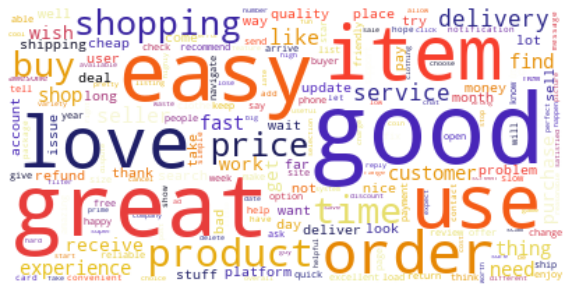

In [11]:
common_words = pd.DataFrame(train_data_features.toarray(), columns = vectorizer.get_feature_names()).sum().sort_values(ascending = False)

wordcloud = WordCloud(max_font_size=70,
                      max_words=200,
                      background_color="white",
                      colormap='CMRmap')
wordcloud.generate_from_frequencies(frequencies=common_words)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [12]:
# Instantiate logistic regression model.
lr = LogisticRegression(solver = 'lbfgs', max_iter = 5000)

# Fit model to training data.
lr.fit(train_data_features, y_train)

# Evaluate model on training data.
print(f'Accuracy score for Train data set: {lr.score(train_data_features, y_train)}')

# Evaluate model on testing data.
print(f'Accuracy score for Test data set: {lr.score(test_data_features, y_test)}')

Accuracy score for Train data set: 0.9348780059680534
Accuracy score for Test data set: 0.9204844655081622


In [13]:
preds = lr.predict(test_data_features)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()


print(f'Specificity: {round(tn / (tn + fp),4)}')
print(f'Sensitivity: {round(tp / (tp + fn),4)}')
print(f'MCC Score: {matthews_corrcoef(y_test,preds)}')

Specificity: 0.7602
Sensitivity: 0.9668
MCC Score: 0.7636027276781705


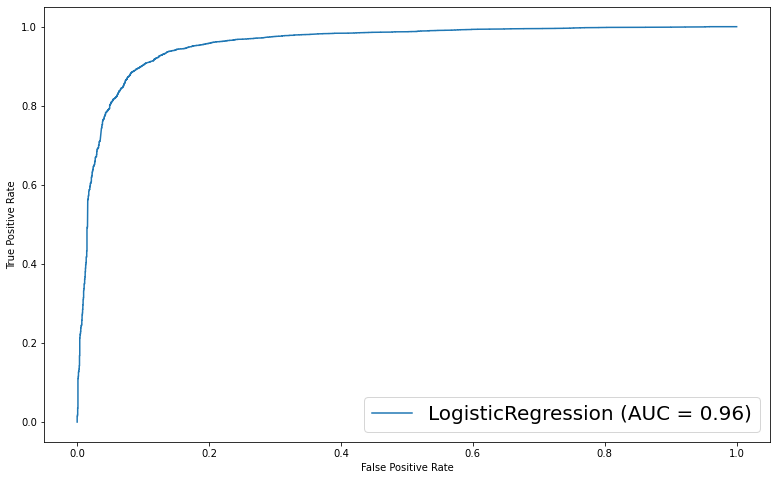

In [14]:
fig, ax = plt.subplots(figsize=(13, 8))
plot_roc_curve(lr, test_data_features, y_test, ax = ax)
plt.legend(prop={"size":20});

## Testing with different vectorizers

### CountVectorizer Logistic Regression

In [15]:
# Setting pipeline for two stages
cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
     ])

pipe_params = {
    'cvec__max_features': [4000, 5000, 6000, 7000, 8000, 9000],
    'cvec__min_df': [3, 4],
    'cvec__max_df': [.2 , .3,],
    'cvec__ngram_range': [(1,1), (1,2)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_cvec_lr = RandomizedSearchCV(cvec_lr, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 20,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'roc_auc') # 5-fold cross-validation.
t0 = time()
gs_cvec_lr.fit(X_train, y_train)
cvec_test_time = time() - t0
print(f'Best CVEC Parameters: {gs_cvec_lr.best_estimator_}')
print('Fit time:  %0.3fs' % cvec_test_time);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


Best CVEC Parameters: Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.3, max_features=6000, min_df=4,
                                 ngram_range=(1, 2))),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  91.109s


### TFIDVectorizer Logistic Regression

In [16]:
# Setting pipeline for two stages
tfid_lr = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tfid__max_features': [4000, 5000, 6000, 7000, 8000, 9000],
    'tfid__min_df': [3, 4],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_tfid_lr = RandomizedSearchCV(tfid_lr, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 20,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'roc_auc') # 5-fold cross-validation.
t0 = time()
gs_tfid_lr.fit(X_train, y_train)
tfid_test_time = time() - t0
print(f'Best TFID Parameters: {gs_tfid_lr.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_test_time);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


Best TFID Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=6000, min_df=3,
                                 ngram_range=(1, 2))),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  92.028s


### HashingVectorizer Logistic Regression

In [17]:
# Setting pipeline for two stages
hash_lr = Pipeline([
    ('hash', HashingVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1)),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'hash__n_features': [4000, 5000, 6000, 7000, 8000, 9000],
    'hash__ngram_range': [(1,1), (1,2)],
    'sampling__sampling_strategy': ['minority', 'not minority'],
    'sampling__k_neighbors': [5, 10]
}

gs_hash_lr = RandomizedSearchCV(hash_lr, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 20,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'roc_auc') # 5-fold cross-validation.

t0 = time()
gs_hash_lr.fit(X_train, y_train)
hash_test_time = time() - t0
print(f'Best HASH Parameters: {gs_hash_lr.best_estimator_}')
print('Fit time:  %0.3fs' % hash_test_time);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


Best HASH Parameters: Pipeline(steps=[('hash', HashingVectorizer(n_features=7000)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(max_iter=5000))])
Fit time:  64.329s


In [18]:
summary = []

summary.append(['LogisticRegression', 'CountVectorizer',
                gs_cvec_lr.best_score_,
                gs_cvec_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_cvec_lr.predict(X_test)),
                round(cvec_test_time)])


summary.append(['LogisticRegression', 'TFIDVectorizer', 
                gs_tfid_lr.best_score_,
                gs_tfid_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_lr.predict(X_test)),
                round(tfid_test_time)])

summary.append(['LogisticRegression', 'HashingVectorizer', 
                gs_hash_lr.best_score_,
                gs_hash_lr.score(X_test,y_test), 
                matthews_corrcoef(y_test, gs_hash_lr.predict(X_test)),
                round(hash_test_time)])


pd.DataFrame(summary, 
             columns = ['model', 
                        'vectorizer', 
                        'train_score', 
                        'test_score',
                        'MCC_score',
                        'time(s)']).style.highlight_max().highlight_min(color = 'red')

,model,vectorizer,train_score,test_score,MCC_score,time(s)
0,LogisticRegression,CountVectorizer,0.953479,0.954819,0.763635,91
1,LogisticRegression,TFIDVectorizer,0.964498,0.966329,0.779235,92
2,LogisticRegression,HashingVectorizer,0.961866,0.965291,0.765913,64


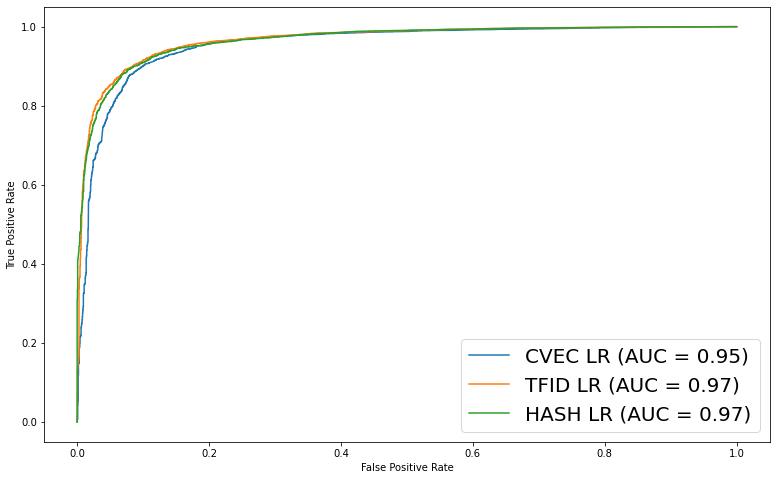

In [19]:
fig, ax = plt.subplots(figsize=(13, 8))
cvec_lr_disp = plot_roc_curve(gs_cvec_lr, X_test, y_test, name = 'CVEC LR', ax = ax)
tfid_lr_disp = plot_roc_curve(gs_tfid_lr, X_test, y_test, name = 'TFID LR', ax = ax)
hash_lr_disp = plot_roc_curve(gs_hash_lr, X_test, y_test, name = 'HASH LR', ax = ax)
plt.legend(prop={"size":20});

## Trying with Different Models

### Logistic Regression

In [20]:
# Setting pipeline for two stages
tfid_lr = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tfid__max_features': [4000, 5000, 6000, 7000, 8000, 9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__k_neighbors': [10, 15],
    'lr__C': list(np.linspace(0, 10, 11))
}

gs_tfid_lr = RandomizedSearchCV(tfid_lr, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 30,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'roc_auc') # 5-fold cross-validation.
t0 = time()
gs_tfid_lr.fit(X_train, y_train)
tfid_lr_test_time = time() - t0
print(f'Best Logistic Regression Parameters: {gs_tfid_lr.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_lr_test_time);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.0min finished


Best Logistic Regression Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=9000, min_df=3)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(C=2.0, max_iter=5000))])
Fit time:  63.460s


### MultinomialNB

In [21]:
# Setting pipeline for two stages
tfid_nb = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tfid__max_features': [4000, 5000, 6000, 7000, 8000, 9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'nb__alpha': list(np.linspace(0,1,11))
}

gs_tfid_nb = RandomizedSearchCV(tfid_nb, # what object are we optimizing?
                                param_distributions=pipe_params, # what parameters values are we searching?
                                random_state = 42, n_iter = 30,
                                cv=5, verbose = 1, n_jobs = -1, scoring = 'roc_auc') # 5-fold cross-validation.
t0 = time()
gs_tfid_nb.fit(X_train, y_train)
tfid_nb_test_time = time() - t0
print(f'Best MultinomialNB Parameters: {gs_tfid_nb.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_nb_test_time);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   32.1s finished


Best MultinomialNB Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=8000, min_df=4,
                                 ngram_range=(1, 2))),
                ('sampling',
                 SMOTE(n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('nb', MultinomialNB(alpha=0.9))])
Fit time:  33.410s


### SGDClassifier

In [22]:
# Setting pipeline for two stages
tfid_clf = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('clf', SGDClassifier())
])

pipe_params = {
    'tfid__max_features': [4000, 5000, 6000, 7000, 8000, 9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__k_neighbors': [10, 15],
    'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
    'clf__penalty': ('l2', 'elasticnet'),
    
    
}

gs_tfid_clf = RandomizedSearchCV(tfid_clf, # what object are we optimizing?
                                 param_distributions=pipe_params, # what parameters values are we searching?
                                 random_state = 42, n_iter = 30,
                                 cv=5, verbose = 1, n_jobs = -1, scoring = 'roc_auc') # 5-fold cross-validation.
t0 = time()
gs_tfid_clf.fit(X_train, y_train)
tfid_clf_test_time = time() - t0
print(f'Best SGDClassifier Parameters: {gs_tfid_clf.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_clf_test_time);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   33.7s finished


Best SGDClassifier Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=5000, min_df=4)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('clf', SGDClassifier())])
Fit time:  34.278s


### RandomForest

In [23]:
# Setting pipeline for two stages
tfid_ran = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('rf', RandomForestClassifier(random_state = 42, min_samples_leaf = 2, min_samples_split = 3))
])

pipe_params = {
    'tfid__max_features': [4000, 5000, 6000, 7000, 8000, 9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__k_neighbors': [10, 15],
    'rf__n_estimators': [100, 300, 500],
    'rf__max_depth': [8, 15, 25],
    'rf__min_samples_split': [5, 15, 100],
    'rf__max_leaf_nodes': [10, None]
}

gs_tfid_ran = RandomizedSearchCV(tfid_ran, # what object are we optimizing?
                                 param_distributions=pipe_params, # what parameters values are we searching?
                                 random_state = 42, n_iter = 30,
                                 cv=5, verbose = 1, n_jobs = -1, scoring = 'roc_auc') # 5-fold cross-validation.
t0 = time()
gs_tfid_ran.fit(X_train, y_train)
tfid_ran_test_time = time() - t0
print(f'Best RandomForest Parameters: {gs_tfid_ran.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_ran_test_time);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.2min finished


Best RandomForest Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=9000, min_df=5)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('rf',
                 RandomForestClassifier(max_depth=25, min_samples_leaf=2,
                                        min_samples_split=15, n_estimators=500,
                                        random_state=42))])
Fit time:  202.886s


### Adaboost

In [24]:
# Setting pipeline for two stages
tfid_ada = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('sampling', SMOTE(random_state=42, n_jobs = -1, sampling_strategy = 'not minority')),
    ('ada', AdaBoostClassifier())
])

pipe_params = {
    'tfid__max_features': [4000, 5000, 6000, 7000, 8000, 9000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'sampling__k_neighbors': [10, 15],
    'ada__n_estimators': [100,150,200],
    'ada__learning_rate': list(np.linspace(0.3,1,5))
}

gs_tfid_ada = RandomizedSearchCV(tfid_ada, # what object are we optimizing?
                                 param_distributions=pipe_params, # what parameters values are we searching?
                                 random_state = 42, n_iter = 30,
                                 cv=5, verbose = 1, n_jobs = -1, scoring = 'roc_auc') # 5-fold cross-validation.
t0 = time()
gs_tfid_ada.fit(X_train, y_train)
tfid_ada_test_time = time() - t0
print(f'Best TFID Parameters: {gs_tfid_ada.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_ada_test_time);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  6.2min finished


Best TFID Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=7000, min_df=4,
                                 ngram_range=(1, 2))),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('ada',
                 AdaBoostClassifier(learning_rate=0.825, n_estimators=200))])
Fit time:  383.829s


### Accuracy & ROC AUC Score

In [25]:
summary = []

summary.append(['LogisticRegression', 'TFIDVectorizer', 
                gs_tfid_lr.best_score_,
                gs_tfid_lr.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_lr.predict(X_test)),
                round(tfid_lr_test_time)])

summary.append(['MultinomialNB', 'TFIDVectorizer', 
                gs_tfid_nb.best_score_,
                gs_tfid_nb.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_nb.predict(X_test)),
                round(tfid_nb_test_time)])

summary.append(['SGDClassifier', 'TFIDVectorizer', 
                gs_tfid_clf.best_score_,
                gs_tfid_clf.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_clf.predict(X_test)),
                round(tfid_clf_test_time)])

summary.append(['RandomForest', 'TFIDVectorizer', 
                gs_tfid_ran.best_score_,
                gs_tfid_ran.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_ran.predict(X_test)),
                round(tfid_ran_test_time)])



summary.append(['Adaboost', 'TFIDVectorizer', 
                gs_tfid_ada.best_score_,
                gs_tfid_ada.score(X_test,y_test),
                matthews_corrcoef(y_test, gs_tfid_ada.predict(X_test)),
                round(tfid_ada_test_time)])


pd.DataFrame(summary, 
             columns = ['model', 
                        'vectorizer', 
                        'train_score', 
                        'test_score',
                        'MCC_score',
                        'time(s)']).style.highlight_max().highlight_min(color = 'red')

,model,vectorizer,train_score,test_score,MCC_score,time(s)
0,LogisticRegression,TFIDVectorizer,0.964697,0.966765,0.780859,63
1,MultinomialNB,TFIDVectorizer,0.962651,0.964346,0.765482,33
2,SGDClassifier,TFIDVectorizer,0.963035,0.965170,0.766919,34
3,RandomForest,TFIDVectorizer,0.937571,0.941086,0.562820,203
4,Adaboost,TFIDVectorizer,0.949363,0.952083,0.726640,384


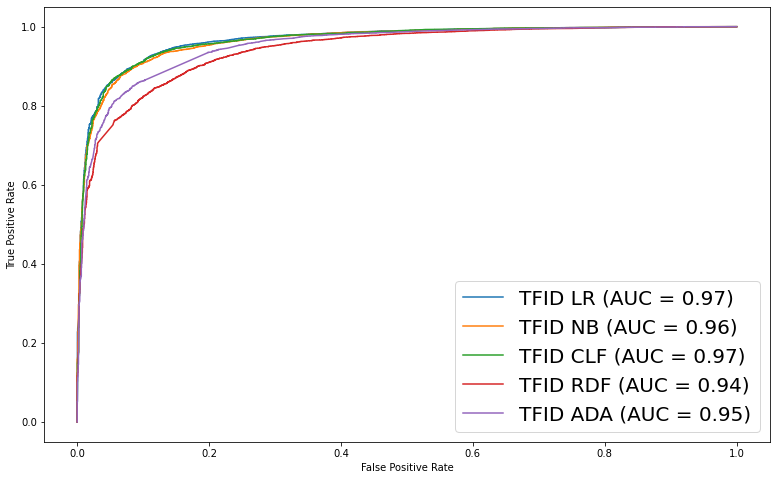

In [26]:
fig, ax = plt.subplots(figsize=(13, 8))
tfid_lr_disp = plot_roc_curve(gs_tfid_lr, X_test, y_test, name = 'TFID LR', ax = ax)
tfid_nb_disp = plot_roc_curve(gs_tfid_nb, X_test, y_test, name = 'TFID NB', ax = ax)
tfid_clf_disp = plot_roc_curve(gs_tfid_clf, X_test, y_test, name = 'TFID CLF', ax = ax)
tfid_ran_disp = plot_roc_curve(gs_tfid_ran, X_test, y_test, name = 'TFID RDF', ax = ax)
tfid_ada_disp = plot_roc_curve(gs_tfid_ada, X_test, y_test, name = 'TFID ADA', ax = ax)
plt.legend(prop={"size":20});

## Confusion Matrix

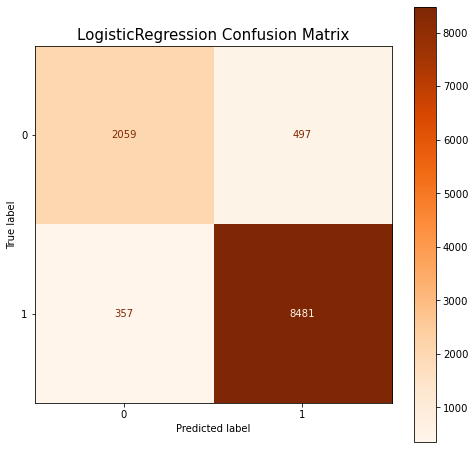

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.title('LogisticRegression Confusion Matrix', fontdict = {'fontsize': 15})
plot_confusion_matrix(gs_tfid_lr, X_test, y_test, ax = ax, cmap='Oranges');

## Checking Misclassified Post

In [28]:
good_reviews_bag = pd.DataFrame(data = [gs_tfid_lr.best_estimator_.named_steps['tfid'].get_feature_names(),
                     gs_tfid_lr.best_estimator_.named_steps['lr'].coef_[0]]).T.rename(columns = {0 : 'Features', 1: 'Coef'}).sort_values(by = 'Coef', ascending = False).reset_index(drop = True)

In [29]:
bad_reviews_bag = pd.DataFrame(data = [gs_tfid_lr.best_estimator_.named_steps['tfid'].get_feature_names(),
                     gs_tfid_lr.best_estimator_.named_steps['lr'].coef_[0]]).T.rename(columns = {0 : 'Features', 1: 'Coef'}).sort_values(by = 'Coef', ascending = True).reset_index(drop = True)

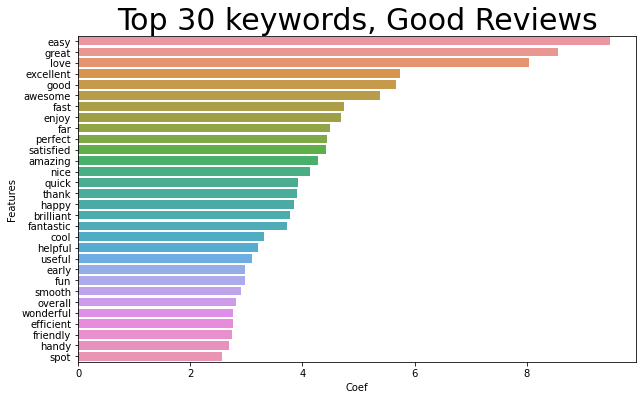

In [30]:
plt.figure(figsize= (10, 6))
plt.title('Top 30 keywords, Good Reviews',fontdict = {'fontsize': 30})
sns.barplot(x = 'Coef', y = 'Features', data = good_reviews_bag[:30]);

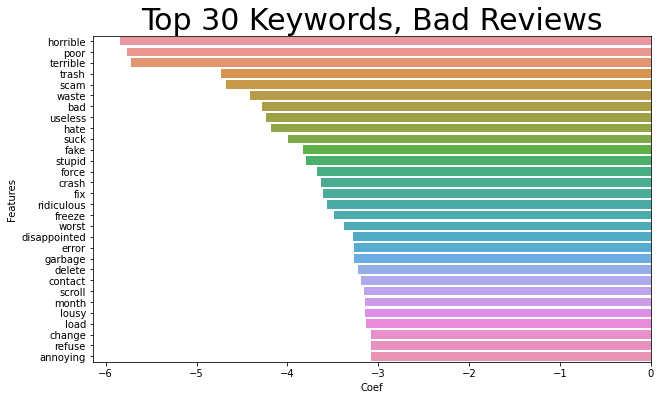

In [31]:
plt.figure(figsize= (10, 6))
plt.title('Top 30 Keywords, Bad Reviews',fontdict = {'fontsize': 30})
sns.barplot(x = 'Coef', y = 'Features', data = bad_reviews_bag[:30]);

In [32]:
# Create DataFrame with column for predicted values.
results = pd.DataFrame(gs_tfid_lr.predict(X_test), columns=['predicted'], index = y_test.index)

# Create column for observed values.
results['actual'] = y_test
results['review'] = df['review']
results['clean_content'] = df['clean_content']

# Find all indices where predicted and true results 
# aren't the same, then save in an array.
ms_class = results[results['predicted']!= results['actual']]
ms_class.head(10)

,predicted,actual,review,clean_content
35328,1,0,They messed up my order of Xbox live gold I wi...,mess order live gold use
32830,1,0,Its been good . I just dont care so much for t...,good not care advertising know woohoo involve ...
53996,0,1,I have a pleasant experience so far with items...,pleasant experience far item cost $ buy worth ...
20487,1,0,Some things I ordered never came,thing order come
1900,1,0,There is number of fraurds out there with no p...,number professionalism
6013,0,1,Notice that apps getting slower & may get hang...,notice get slow & prolong use
46859,1,0,Way to high i don't like it,way high like
32152,1,0,Why would amazon despatch a harddrive loosely ...,loosely massive box bubble wrap secure place n...
36547,1,0,"Amazon your price is ridiculously expensive , ...",price ridiculously expensive unaffordable
17246,1,0,Big scammers they are big scammers,big big


### Comments
- From the misclassified post we can see the some comments are rated wrongly if we were to just look at the reviews directly.
- Some reviews can also be viewed as ambiguous, meaning that they are not negative or positive.

## Train data on whole dataset

In [33]:
best_model = gs_tfid_lr.best_estimator_

In [34]:
best_model.fit(df['clean_content'], df['rate'])

Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=9000, min_df=3)),
                ('sampling',
                 SMOTE(k_neighbors=10, n_jobs=-1, random_state=42,
                       sampling_strategy='not minority')),
                ('lr', LogisticRegression(C=2.0, max_iter=5000))])

In [35]:
filename = 'Best_Model_P1.sav'
pickle.dump(best_model, open('./model_pickles/' + filename, 'wb'))